❓ **Problem**: Make predictions in terms of the quantity of a given product in the next 30 days
- Data: Order / Store / Product data 
- Input: Store ID, Product ID
- Output: Forecast of quantity in the next 30 days


⏭**Basic Flow**

Because of the toy model, we only handle the basic operations in data processing & model development

- Clean Data
- Create vocabulary of Store - Product ID
- Simple EDA
- Training data pipeline process
- Baseline model
- Export artifact (pickle pipeline, baseline model, training data)

Import libraries

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

from itertools import product
# For Facets data visualization
from IPython.core.display import display, HTML
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
%matplotlib inline

Define visualization functions

In [2]:
def dive_data(data, sample_nbr=0):
  '''
    data: Pandas DataFrame
    sample: Get a fraction of data or full data. 0 - full data, other: num of sample
    output: HTML visualization
  '''
  if sample_nbr!=0:
    data = data.sample(sample_nbr)
  jsonstr = data.to_json(orient='records')
  HTML_TEMPLATE = """
          <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
          <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
          <facets-dive id="elem" height="600"></facets-dive>
          <script>
            var data = {jsonstr};
            document.querySelector("#elem").data = data;
          </script>"""
  html = HTML_TEMPLATE.format(jsonstr=jsonstr)
  display(HTML(html))
def overview_data(data, sample_nbr=0):
  '''
    data: Pandas DataFrame
    sample: Get a fraction of data or full data. 0 - full data, other: num of sample
    output: HTML visualization
  '''
  gfsg = GenericFeatureStatisticsGenerator()
  if sample_nbr!=0:
    data = data.sample(sample_nbr)
  proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': data}])
  protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
  HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
  html = HTML_TEMPLATE.format(protostr=protostr)
  display(HTML(html))

# Clean Data

##  Order data

In [3]:
df_order = pd.read_csv('model/data/source-data/data_order.csv')

In [4]:
df_order.columns= [x.lower() for x in list(df_order.columns)]
df_order

order_id  store_id  region_id  brand_id  product_id  \
0         23501       274          2      1779        4048   
1         23463       629          3      1953        4661   
2         23501       274          2      1543        3956   
3         23502       275          2      1119        2552   
4         23502       275          2      1119        3668   
...         ...       ...        ...       ...         ...   
75313     23463       629          3      1410        3520   
75314     23506      1897          2      1503        3866   
75315     23506      1897          2      1311        3170   
75316     23506      1897          2      1976        4777   
75317     23291       655          3      1886        4431   

       product_variant_id  quantity  variant_case_price_cents checkout_date  
0                   12344         1                      5200    2022-01-25  
1                   14243         1                      2004    2022-01-24  
2                   12149         1                      2010    2022-01-25  
3                    8275         4                      3600    2022-01-25  
4                   11553         2                      2900    2022-01-25  
...                   ...       ...                       ...           ...  
75313               10901         1                      3600    2022-01-24  
75314               11946         1                      4497    2022-01-25  
75315                9912         1                      2892    2022-01-25  
75316               14537         1                      2700    2022-01-25  
75317               13686         1                     23400    2022-01-19  

[75318 rows x 9 columns]

In [5]:
# Convert types
df_order['checkout_date'] = pd.to_datetime(df_order['checkout_date'])
df_order['checkout_month'] = df_order['checkout_date'].dt.month

Create revenue feature = price * quantity 

In [6]:
df_order['revenue_cents'] = df_order['variant_case_price_cents'] * df_order['quantity']

**Order data only consists of 5 months & output is forecast number of quantity in the next month, we don't consider timeseries problem here**

Group order by month


In [7]:
# group by month
group_order = df_order.groupby(['store_id','product_id','checkout_month'])\
                      .agg({
                            'quantity': ['sum'],
                            'variant_case_price_cents': ['mean'],
                            'revenue_cents': ['sum'],
                            #'region_id': pd.Series.nunique, # How many region where custom located?
                            'order_id': pd.Series.nunique, # How many oder customer made?
                            #'brand_id': pd.Series.nunique, # How many brand of product?
                            'product_variant_id': pd.Series.nunique # How many variant (sub category) of product?
                      })
group_order.columns = ['quantity','variant_case_price_cents','revenue_cents','order_cnt','product_variant_cnt']
group_order.reset_index(inplace=True)
group_order

store_id  product_id  checkout_month  quantity  \
0            10        2071               1         5   
1            10        2191               1        14   
2            10        2679               1         1   
3            10        3037               1         1   
4            10        3044               1        12   
...         ...         ...             ...       ...   
22773      2623        2193               5         3   
22774      2623        2536               5         4   
22775      2623        2587               5         4   
22776      2623        3013               5         1   
22777      2623        3155               5         6   

       variant_case_price_cents  revenue_cents  order_cnt  product_variant_cnt  
0                   5900.000000          28700          1                    4  
1                   5700.000000          79800          1                    4  
2                   7500.000000           7500          1                    1  
3                   6400.000000           6400          1                    1  
4                   3450.000000          41400          2                    3  
...                         ...            ...        ...                  ...  
22773               4600.000000          13800          1                    3  
22774               1550.000000           6200          1                    2  
22775               3304.000000          13216          1                    2  
22776               3600.000000           3600          1                    1  
22777               2066.666667          12400          1                    6  

[22778 rows x 8 columns]

Over view data (in this sample we use [google's facets tool](https://pair-code.github.io/facets/) for productivity, explore individual observations)

In [8]:
overview_data(group_order)

✅ There is cleaned data with zero of missing value 
The number of orders per month is similar, The median order number of products per store is 3

Quantity, variant_case_price_cents with high std dev, lets see more detail 👇

<AxesSubplot: xlabel='variant_case_price_cents'>

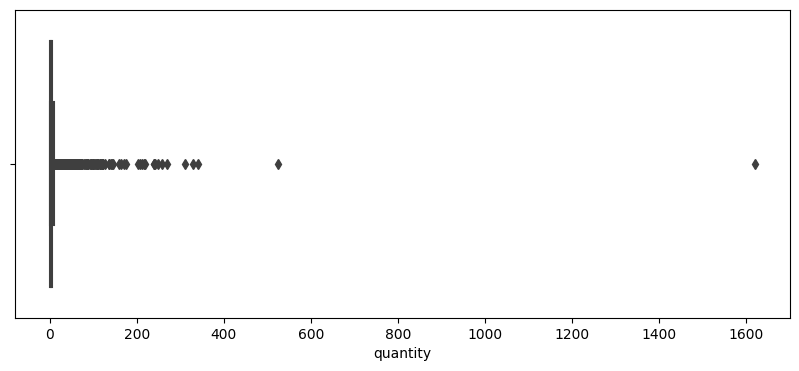

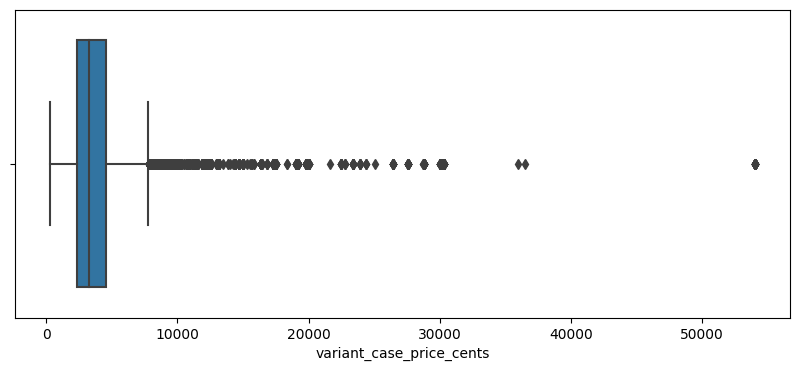

In [9]:
plt.figure(figsize=(10,4))
sns.boxplot(x=group_order.quantity)
plt.figure(figsize=(10,4))
sns.boxplot(x=group_order.variant_case_price_cents)

In [10]:
# Not to much value, we can delete it
group_order =  group_order[group_order.quantity<300]
group_order =  group_order[group_order.variant_case_price_cents<30000]

More dive view in data distribution, data interaction

In [11]:
dive_data(group_order)

# Create Vocab data

Store + product data aren't available in training phase should be zero in serving phase

Train data set contains only pairs which were sold in the past and may be it doesnt avaiable in prediction request. The main idea is create a vocabolary (matrix) of Store + Product data.

In [24]:
matrix = []
cols = ['checkout_month','store_id','product_id']
for i in range(1,6):
    sales = group_order[group_order.checkout_month==i]
    matrix.append(np.array(list(product([i], sales.store_id.unique(), sales.product_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

In [25]:
matrix

checkout_month  store_id  product_id
0                     1        10        2071
1                     1        10        2191
2                     1        10        2679
3                     1        10        3037
4                     1        10        3044
...                 ...       ...         ...
1193750               5      2623        3217
1193751               5      2623        5567
1193752               5      2623        3486
1193753               5      2623        4562
1193754               5      2623        5207

[1193755 rows x 3 columns]

## Store data

In [14]:
df_store = pd.read_csv('model/data/source-data/data_metadata_store.csv')
df_store.columns = [x.lower() for x in list(df_store.columns)]
df_store['store_type'] = df_store['store_type'].apply(lambda x: str(x).replace(" ",""))
df_store.rename(columns={"region_id":"store_region_id"}, inplace = True)
df_store.head(5)

store_id    store_type  store_region_id  store_size
0       982   Independent              3.0         1.0
1      1225  Naturalchain             12.0         5.0
2      1969  Naturalchain             11.0         4.0
3      2331        Online              4.0         5.0
4      2235   Independent              NaN         4.0

In [15]:
overview_data(df_store)

👉 store_region_id, store_size and store_type are categorical feature. They have to be handled null value later (3% to 16% of features are null value)

👉 store_region_id & store_type should be encoded as one hot

👉 store_size is categorical but should keep as ordinal 

In [16]:
dive_data(df_store)

## Product data

With null features, we're gonna process lates

In [18]:
df_product = pd.read_csv('model/data/source-data/data_metadata_product.csv')
df_product.columns = [x.lower() for x in list(df_product.columns)]

In [19]:
df_product['product_metadata'] = df_product['product_metadata'].apply(lambda x: x.replace(" ",""))
df_product

product_id  product_metadata
0           6280         SnackBars
1           6499  Sweeteners+Syrup
2           5532          Desserts
3           2608   HempIngestibles
4           2252              Hemp
...          ...               ...
8885        4218             Chill
8886        3011          Wellness
8887        1189           Grocery
8888        4198            Snacks
8889        4165          Beverage

[8890 rows x 2 columns]

In [20]:
overview_data(df_product)

A product may belong to different sub-categories

Grocery & Wellness products are best seller

Clean but spare data (88 categories)

👉 product_metadata will be handled by one-hot encode below. But in reality & have more time, **Embedding** method may be better

In [21]:
# Using OneHotEncoder
df_product['product_metadata'] = LabelEncoder().fit_transform(df_product['product_metadata'])
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)

onehot_encoded_store= onehot.fit_transform(df_product[["product_metadata"]])
df_product = df_product.drop('product_metadata',axis=1)
df_store_one_hot = pd.DataFrame(onehot_encoded_store,columns = onehot.get_feature_names_out(['product_metadata']))
# concat
df_product = pd.concat([df_product,df_store_one_hot],axis = 1)

In [22]:
df_product = df_product.groupby('product_id').sum().reset_index()
df_product

product_id  product_metadata_0  product_metadata_1  product_metadata_2  \
0            127                 0.0                 0.0                 0.0   
1            133                 0.0                 0.0                 0.0   
2            134                 0.0                 0.0                 0.0   
3            136                 0.0                 0.0                 0.0   
4            137                 0.0                 0.0                 0.0   
...          ...                 ...                 ...                 ...   
4474        6718                 0.0                 0.0                 0.0   
4475        6719                 0.0                 0.0                 0.0   
4476        6720                 0.0                 0.0                 0.0   
4477        6721                 0.0                 0.0                 0.0   
4478        6722                 0.0                 0.0                 0.0   

      product_metadata_3  product_metadata_4  product_metadata_5  \
0                    0.0                 0.0                 0.0   
1                    0.0                 0.0                 0.0   
2                    0.0                 0.0                 0.0   
3                    0.0                 0.0                 0.0   
4                    0.0                 0.0                 0.0   
...                  ...                 ...                 ...   
4474                 0.0                 0.0                 1.0   
4475                 0.0                 0.0                 0.0   
4476                 0.0                 0.0                 0.0   
4477                 0.0                 0.0                 0.0   
4478                 0.0                 0.0                 0.0   

      product_metadata_6  product_metadata_7  product_metadata_8  ...  \
0                    0.0                 0.0                 0.0  ...   
1                    0.0                 0.0                 0.0  ...   
2                    0.0                 0.0                 0.0  ...   
3                    0.0                 0.0                 1.0  ...   
4                    0.0                 0.0                 0.0  ...   
...                  ...                 ...                 ...  ...   
4474                 0.0                 0.0                 0.0  ...   
4475                 0.0                 0.0                 0.0  ...   
4476                 0.0                 0.0                 0.0  ...   
4477                 0.0                 0.0                 0.0  ...   
4478                 0.0                 0.0                 0.0  ...   

      product_metadata_78  product_metadata_79  product_metadata_80  \
0                     0.0                  0.0                  0.0   
1                     0.0                  0.0                  0.0   
2                     0.0                  0.0                  0.0   
3                     0.0                  0.0                  0.0   
4                     0.0                  0.0                  1.0   
...                   ...                  ...                  ...   
4474                  0.0                  0.0                  0.0   
4475                  0.0                  0.0                  0.0   
4476                  0.0                  0.0                  0.0   
4477                  0.0                  0.0                  0.0   
4478                  0.0                  0.0                  0.0   

      product_metadata_81  product_metadata_82  product_metadata_83  \
0                     0.0                  0.0                  0.0   
1                     0.0                  0.0                  1.0   
2                     0.0                  0.0                  0.0   
3                     0.0                  0.0                  0.0   
4                     0.0                  0.0                  0.0   
...                   ...                  ...                  ...   
4

**Merge vocab data**



In [26]:
data = matrix.merge(group_order, on = ['store_id',	'product_id',	'checkout_month'], how='left')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1193755 entries, 0 to 1193754
Data columns (total 8 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   checkout_month            1193755 non-null  int16  
 1   store_id                  1193755 non-null  int16  
 2   product_id                1193755 non-null  int16  
 3   quantity                  22688 non-null    float64
 4   variant_case_price_cents  22688 non-null    float64
 5   revenue_cents             22688 non-null    float64
 6   order_cnt                 22688 non-null    float64
 7   product_variant_cnt       22688 non-null    float64
dtypes: float64(5), int16(3)
memory usage: 61.5 MB


👉 Because we are calculating agg of orders every month, but each month has a different number of days. Day in month is considered as a feature

In [28]:
days = pd.Series([0,31,28,31,30,31,30,31,31,30,31,30,31])
data['days'] = data['checkout_month'].map(days)

<AxesSubplot: >

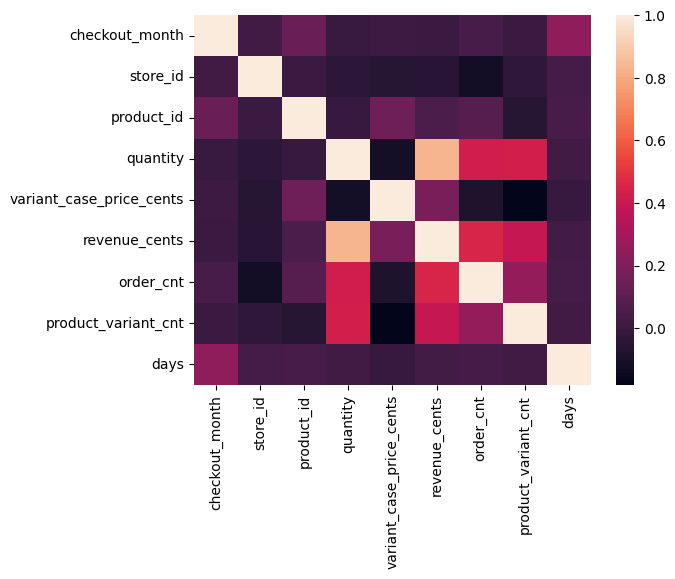

In [29]:
sns.heatmap(data.corr())

# Merge datasets

👉 The label of the predictive problem is the number of sales in the next 1 month which is not available at the time of prediction.

We are using `quantity` of May for label and the remaining months data is training data to avoid data leakage

In [36]:
def split_data(_data,nbr_of_lag=4,predict_month = 5):
  '''
  Split data to training data & label data
    nbr_of_lag: The number of months that we want to average
    predict_month: Prediction month (label)
    df_train, df_label
  '''
  _data = _data.fillna(0)
  begin_month = predict_month - nbr_of_lag
  df_train = _data[_data.checkout_month.between(begin_month,predict_month-1)]
  df_label = _data[_data.checkout_month==predict_month][['store_id','product_id','quantity']]
  df_label.rename(columns = {'quantity':'label'},inplace=True)

  return df_train, df_label

In [37]:
df_train, df_label = split_data(data)
# conver to float to agg data later
df_train['days'] = df_train.days.astype(float)
df_train.drop('checkout_month', axis= 1, inplace=True)


Aggreate train data

In [38]:
df_train = df_train.groupby(['store_id',	'product_id']).mean().reset_index()

Merge label data

In [39]:
df_train=df_train.merge(df_label, on = ['store_id',	'product_id'], how='left')
df_train=df_train[~((df_train['order_cnt']>0) & pd.isna(df_train['label']))]

df_train = df_train.merge(df_store, on ='store_id',how='left')

In [ ]:
#df_train.to_csv('data/training_data_month_5_raw.csv',header=True, index=False)

# Pipeline

Create a simple pipeline for using in next time & more clear code purpose



In [41]:
# define columns
col_id = ['store_id','product_id' ]
col_cat_zero = ['label','quantity','variant_case_price_cents','revenue_cents','order_cnt','product_variant_cnt','days','store_size']
col_cat_one_hot = ['store_type','store_region_id']

feature = col_cat_zero+col_cat_one_hot

# Preprocessing for categorical data covert zero
categorical_transformer_ordinal_zero = Pipeline(verbose=False,steps=[
    ('imputer_cat_zero', SimpleImputer(strategy = 'constant', fill_value = 0))
])
# Preprocessing for categorical data most frequent
categorical_transformer_ordinal_most_freq = Pipeline(verbose=False,steps=[
    ('imputer_cat_most_freq', SimpleImputer(strategy = 'most_frequent'))
])
# Preprocessing for categorical data one-hot
categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

preprocessor_impute = ColumnTransformer(verbose=False,
    transformers=[ 
        ('cat_ordinal_zero', categorical_transformer_ordinal_zero, col_id + col_cat_zero),
        ('cat_onehot', categorical_transformer_onehot, col_cat_one_hot)
    ])

preprocess_pipeline = Pipeline(verbose=False,steps=[
                    ('preprocessor', preprocessor_impute),
                    ])

print("transforming")
categorical_transformer_onehot.fit(df_train[col_cat_one_hot])
one_hot_name = list(categorical_transformer_onehot.get_feature_names_out())

preprocess_pipeline.fit(df_train)

transforming


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ordinal_zero',
                                                  Pipeline(steps=[('imputer_cat_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['store_id', 'product_id',
                                                   'label', 'quantity',
                                                   'variant_case_price_cents',
                                                   'revenue_cents', 'order_cnt',
                                                   'product_variant_cnt',
                                                   'days', 'store_size']),
                                                 ('cat_onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['store_type',
                                                   'store_region_id'])]))])

In [42]:
df_train = pd.DataFrame(preprocess_pipeline.transform(df_train),columns = col_id+col_cat_zero+one_hot_name)

In [43]:
df_train = df_train.merge(df_product, on ='product_id', how='left')

Write data train, pipeline to file

In [44]:
import joblib

df_train.drop('label',axis=1).to_csv('model/data/train-data/vocab_data_month_5.csv',header=True, index=False)
joblib.dump(preprocess_pipeline, 'model/data/train-data/process_pipeline.pkl')

['model/data/train-data/process_pipeline.pkl']

In [45]:
df_train.drop(['store_id','product_id'],axis=1,inplace=True)

Export data train

In [47]:
df_train.drop_duplicates(inplace=True)
df_train.to_csv('model/data/train-data/training_data_month_5.csv',header=True, index=False)

# MODEL

In [48]:
df_train = pd.read_csv('https://github.com/hausuresh/pf-model/raw/main/model/data/train-data/training_data_month_5.zip')

Set random_state for stable training


In [49]:
rand=69

## Train/ Test split

👉 We don't want the training/ testing dataset to be completely valued at 0

In [51]:
df_train_avl = df_train[df_train['label']>0]
df_train_notavl = df_train[df_train['label']==0]

In [52]:
X_train_avl, X_test_avl, y_train_avl, y_test_avl = train_test_split(df_train_avl.drop('label',axis=1), df_train_avl['label'], test_size=0.3, random_state=rand)
X_train_notavl, X_test_notavl, y_train_notavl, y_test_notavl = train_test_split(df_train_notavl.drop('label',axis=1), df_train_notavl['label'], test_size=0.3, random_state=rand)

In [53]:
X_train = pd.concat([X_train_avl,X_train_notavl])
y_train = pd.concat([y_train_avl,y_train_notavl])
X_test = pd.concat([X_test_avl,X_test_notavl])
y_test = pd.concat([y_test_avl,y_test_notavl])

In [57]:
print(y_train[y_train>0].count())
print(y_test[y_test>0].count())

2790
1197


## Baseline Model

We are using a simple linear model for this toy example: ElasticNet


In [ ]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(random_state=rand)
model.fit(X_train, y_train)

Using mse, rmse for regression problem

In [112]:
y_pred = model.predict(X_test)
#mse
print("Baseline mse loss: {}".format(mean_squared_error(y_test,y_pred)))
#rmse
print("Baseline rmse loss: {}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

Baseline mse loss: 3.0045741625840465
Baseline rmse loss: 1.7333707516235661


In [74]:
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 69,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

## Optimize model

There are some methods to tunning our model's hyperparameter

  - Random Search
  - Grid Search
  - Bayesian Search

Make it simple first with GridSearchCV

In [104]:

from sklearn.model_selection import GridSearchCV
estimator = ElasticNet(random_state=rand)
param_grid = {
    'alpha': [0.5,1],
    'l1_ratio': [0.05,0.5,0.7,0.9]
}
gbm = GridSearchCV(estimator, param_grid, n_jobs=-1, scoring='neg_mean_squared_error')
gbm.fit(X_train, y_train)
print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'alpha': 1, 'l1_ratio': 0.9}


In [110]:
model = ElasticNet(alpha=gbm.best_params_.get('alpha'),l1_ratio=gbm.best_params_.get('l1_ratio'),random_state=rand)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred)

#mse
print("Optimized mse loss: {}".format(mean_squared_error(y_test,y_pred)))
#rmse
print("Optimized rmse loss: {}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

Optimized mse loss: 2.8164450459794206
Optimized rmse loss: 1.678226756424596


Export model

In [ ]:
import pickle
filename = 'model/model.sav'
pickle.dump(model, open(filename, 'wb'))

# Some test case

Unit test some cases:
- label > 0
- label = 0

In [ ]:
source = pd.read_csv('data/vocab_data_month_5.csv')
source

store_id  product_id  label  quantity  variant_case_price_cents  \
0           10.0       155.0    0.0       0.0                       0.0   
1           10.0       156.0    0.0       0.0                       0.0   
2           10.0       166.0    0.0       0.0                       0.0   
3           10.0       242.0    0.0       0.0                       0.0   
4           10.0       300.0    0.0       0.0                       0.0   
...          ...         ...    ...       ...                       ...   
463324    2565.0      5456.0    0.0       0.0                       0.0   
463325    2565.0      5477.0    0.0       0.0                       0.0   
463326    2565.0      5484.0    0.0       0.0                       0.0   
463327    2565.0      5532.0    0.0       0.0                       0.0   
463328    2565.0      6267.0    0.0       0.0                       0.0   

        revenue_cents  order_cnt  product_variant_cnt       days  store_size  \
0                 0.0        0.0                  0.0  28.000000         4.0   
1                 0.0        0.0                  0.0  29.500000         4.0   
2                 0.0        0.0                  0.0  31.000000         4.0   
3                 0.0        0.0                  0.0  31.000000         4.0   
4                 0.0        0.0                  0.0  29.666667         4.0   
...               ...        ...                  ...        ...         ...   
463324            0.0        0.0                  0.0  30.000000         2.0   
463325            0.0        0.0                  0.0  30.000000         2.0   
463326            0.0        0.0                  0.0  30.000000         2.0   
463327            0.0        0.0                  0.0  30.000000         2.0   
463328            0.0        0.0                  0.0  30.000000         2.0   

        ...  product_metadata_78  product_metadata_79  product_metadata_80  \
0       ...                  0.0                  0.0                  0.0   
1       ...                  0.0                  0.0                  0.0   
2       ...                  0.0                  0.0                  0.0   
3       ...                  0.0                  0.0                  0.0   
4       ...                  0.0                  0.0                  0.0   
...     ...                  ...                  ...                  ...   
463324  ...                  0.0                  0.0                  0.0   
463325  ...                  0.0                  0.0                  0.0   
463326  ...                  0.0                  0.0                  0.0   
463327  ...                  0.0                  0.0                  0.0   
463328  ...                  0.0                  0.0                  0.0   

        product_metadata_81  product_metadata_82  product_metadata_83  \
0                       0.0                  0.0                  0.0   
1                       0.0                  0.0                  0.0   
2                       0.0                  0.0                  0.0   
3                       0.0                  0.0                  0.0   
4                       0.0                  1.0                  0.0   
...                     ...                  ...                  ...   
463324                  0.0                  0.0                  0.0   
463325                  0.0                  0.0                  0.0   
463326                  0.0                  0.0                  0.0   
463327                  0.0                  0.0                  0.0   
463328                  0.0                  0.0                  0.0   

        product_metadata_84  product_metadata_85  product_metadata_86  \
0                       0.0                  0.0                  0.0   
1                       0.0                  0.0                  0.0   
2                       0.0                  0.0                  0.0   
3                       0.0             

In [ ]:
source[source['label']==0]

store_id  product_id  label  quantity  variant_case_price_cents  \
0           10.0       155.0    0.0       0.0                       0.0   
1           10.0       156.0    0.0       0.0                       0.0   
2           10.0       166.0    0.0       0.0                       0.0   
3           10.0       242.0    0.0       0.0                       0.0   
4           10.0       300.0    0.0       0.0                       0.0   
...          ...         ...    ...       ...                       ...   
463324    2565.0      5456.0    0.0       0.0                       0.0   
463325    2565.0      5477.0    0.0       0.0                       0.0   
463326    2565.0      5484.0    0.0       0.0                       0.0   
463327    2565.0      5532.0    0.0       0.0                       0.0   
463328    2565.0      6267.0    0.0       0.0                       0.0   

        revenue_cents  order_cnt  product_variant_cnt       days  store_size  \
0                 0.0        0.0                  0.0  28.000000         4.0   
1                 0.0        0.0                  0.0  29.500000         4.0   
2                 0.0        0.0                  0.0  31.000000         4.0   
3                 0.0        0.0                  0.0  31.000000         4.0   
4                 0.0        0.0                  0.0  29.666667         4.0   
...               ...        ...                  ...        ...         ...   
463324            0.0        0.0                  0.0  30.000000         2.0   
463325            0.0        0.0                  0.0  30.000000         2.0   
463326            0.0        0.0                  0.0  30.000000         2.0   
463327            0.0        0.0                  0.0  30.000000         2.0   
463328            0.0        0.0                  0.0  30.000000         2.0   

        ...  product_metadata_78  product_metadata_79  product_metadata_80  \
0       ...                  0.0                  0.0                  0.0   
1       ...                  0.0                  0.0                  0.0   
2       ...                  0.0                  0.0                  0.0   
3       ...                  0.0                  0.0                  0.0   
4       ...                  0.0                  0.0                  0.0   
...     ...                  ...                  ...                  ...   
463324  ...                  0.0                  0.0                  0.0   
463325  ...                  0.0                  0.0                  0.0   
463326  ...                  0.0                  0.0                  0.0   
463327  ...                  0.0                  0.0                  0.0   
463328  ...                  0.0                  0.0                  0.0   

        product_metadata_81  product_metadata_82  product_metadata_83  \
0                       0.0                  0.0                  0.0   
1                       0.0                  0.0                  0.0   
2                       0.0                  0.0                  0.0   
3                       0.0                  0.0                  0.0   
4                       0.0                  1.0                  0.0   
...                     ...                  ...                  ...   
463324                  0.0                  0.0                  0.0   
463325                  0.0                  0.0                  0.0   
463326                  0.0                  0.0                  0.0   
463327                  0.0                  0.0                  0.0   
463328                  0.0                  0.0                  0.0   

        product_metadata_84  product_metadata_85  product_metadata_86  \
0                       0.0                  0.0                  0.0   
1                       0.0                  0.0                  0.0   
2                       0.0                  0.0                  0.0   
3                       0.0             

We will do preprocessing task (get features of [store_id + product_id] from vocab data in this case) in serving phase

In [ ]:
request = pd.DataFrame([{"store_id":2519,"product_id":5273}]).merge(source, on = ['store_id', 'product_id'], how='left')
int(model.predict(request.drop(['store_id','product_id','label'],axis=1)))

11

In [ ]:
request = pd.DataFrame([{"store_id":10,"product_id":166}]).merge(source, on = ['store_id', 'product_id'], how='left')
int(model.predict(request.drop(['store_id','product_id','label'],axis=1)))

0

# Note

There are steps need to be processed to increase model's accuracy:
- Imbalance class problem
- Scale data
- Use another complex model (LGBM, XGBosst...etc)
- ...